# 6. Time series analysis
** **
## Table of contents:

1. Importing libraries <br>
2. Importing dataframe <br>
3. Wrangling, subsetting, plotting <br>
4. Time series analysis
    - 4.1 Decomposition
    - 4.2 Stationarity test
    - 4.3 Autocorrelation test
5. Stationarizing data
6. Testing: second round
    - 6.1 Stationarity test
7. Stationarizing data: second round
8. Testing: third round round
    - 8.1 Stationarity test
    - 8.2 Autocorrelation test

# 1. Importing libraries
** **

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
from datetime import datetime
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# 2. Importing dataframe
** **

For this analysis I can't use the same dataframe used in previous scripts, because my only time variable is in a "Year" format and not in a Y-M-D. <br>
So I will use a Quandl dataset that you can find at this link: <br>
https://data.nasdaq.com/data/BP/C02_EMMISSIONS_USA-carbon-dioxide-co2-emmissions-usa. <br>
The time series contain USA CO2 total emissions recorded by Year (from 1965 to 2020).

In [2]:
# Configuring my API key
quandl.ApiConfig.api_key = 'VBhtv_QSxxRFoxhZH1Eb'

In [3]:
# Importing the dataframe from "Energy consumption and production - Carbon Dioxide (CO2) Emmissions - USA"
data_co2 = quandl.get('BP/C02_EMMISSIONS_USA')

In [4]:
# Checking the head
data_co2.head(5)

,Value
Date,
1965-12-31,3451.891855
1966-12-31,3639.795004
1967-12-31,3738.161319
1968-12-31,3947.343459
1969-12-31,4117.396247


As already said, data contains yearly amount of USA CO2 emissions from 1965 to 2020.

In [5]:
# Checking the shape
data_co2.shape

(56, 1)

# 3. Wrangling, subsetting, plotting
** **

I plan to subset this dataframe and use only the records from 1980 to 2020 because I would like to use year 2000 as a kind of separator (so 1980 is 20 years before 2000 and 2020 is 20 years after 2000). <br>
In order to do so, I have to reset the index so "Date" will change from index to a variable.

In [6]:
# Creating a new subset, resetting the index
data_co2_ind = data_co2.reset_index()

In [7]:
# Checking the result
data_co2_ind.head()

,Date,Value
0,1965-12-31,3451.891855
1,1966-12-31,3639.795004
2,1967-12-31,3738.161319
3,1968-12-31,3947.343459
4,1969-12-31,4117.396247


Great! Now I can subset my dataframe, using the loc function.

In [8]:
# Filtering the date variable
data_co2_sub = data_co2_ind.loc[(data_co2_ind['Date'] >= '1980-12-31')]

In [9]:
# Checking the shape
data_co2_sub.shape

(41, 2)

15 rows less! Perfect!

In [10]:
# Checking the head
data_co2_sub.head()

,Date,Value
15,1980-12-31,4749.345114
16,1981-12-31,4601.680051
17,1982-12-31,4376.272973
18,1983-12-31,4337.413667
19,1984-12-31,4564.867043


Everything seems right. Now, using "datetime", we can replace our current index with our "Date" column.

In [11]:
# Replacing current index with Date variable
data_co2_sub['datetime'] = pd.to_datetime(data_co2_sub['Date']) # Creating a new "datetime" column from "Date" column.
data_co2_sub = data_co2_sub.set_index('datetime') # Setting the new column as the new index.
data_co2_sub.drop(['Date'], axis=1, inplace=True) # We don't need anymore the "Date" column.
data_co2_sub.head()

,Value
datetime,
1980-12-31,4749.345114
1981-12-31,4601.680051
1982-12-31,4376.272973
1983-12-31,4337.413667
1984-12-31,4564.867043


Great! Now, just to be sure, let's check for missing values or duplicates.

In [12]:
# Check for missing values

data_co2_sub.isnull().sum() 

Value    0
dtype: int64

0 missing values.

In [13]:
# Check for duplicates

dups = data_co2_sub.duplicated()
dups.sum()

0

0 duplicates.

Let's plot our time series and take a look on how it appears.

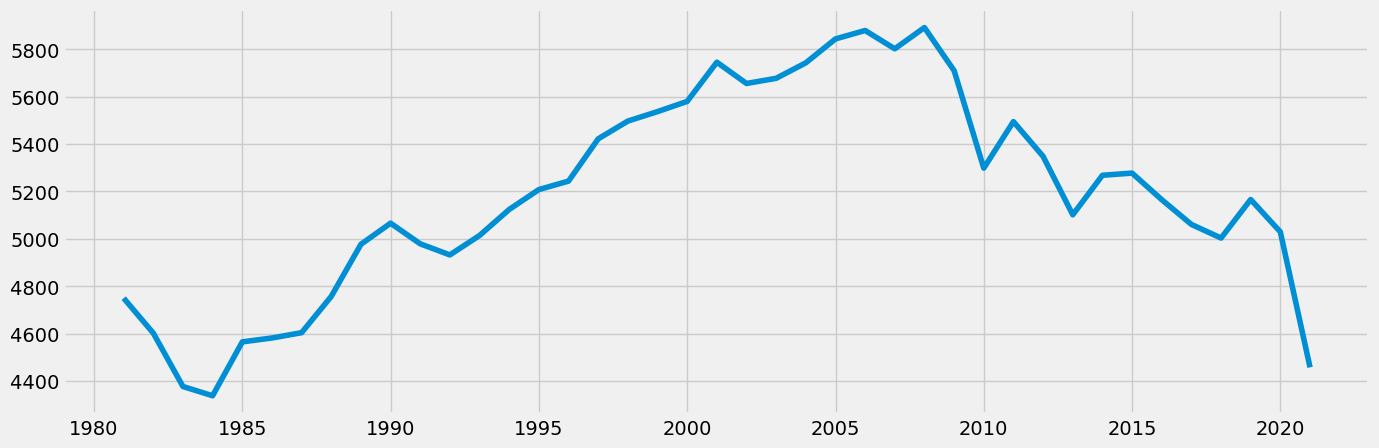

In [14]:
# Plotting our time series

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_co2_sub)

There are some fluctuations, but we can say  that there is a general upwarding trend from 1985 to 2008 and a descending trend from 2008 to 2020.

# 4. Time series analysis
** **

## 4.1 Decomposition

Let's start our analysis by decomposing our time series. This will help us to understand if our data is stationary or non-stationary. <br>
Considering the chart above, it seems our data has a non linear fashion, so we should use a multiplicative method.

In [15]:
# Decompose the time series using a multiplicative model

decomposition = sm.tsa.seasonal_decompose(data_co2_sub, model='multiplicative')

In [16]:
# Let's set a fixed size for all our charts

rcParams['figure.figsize'] = 18, 7

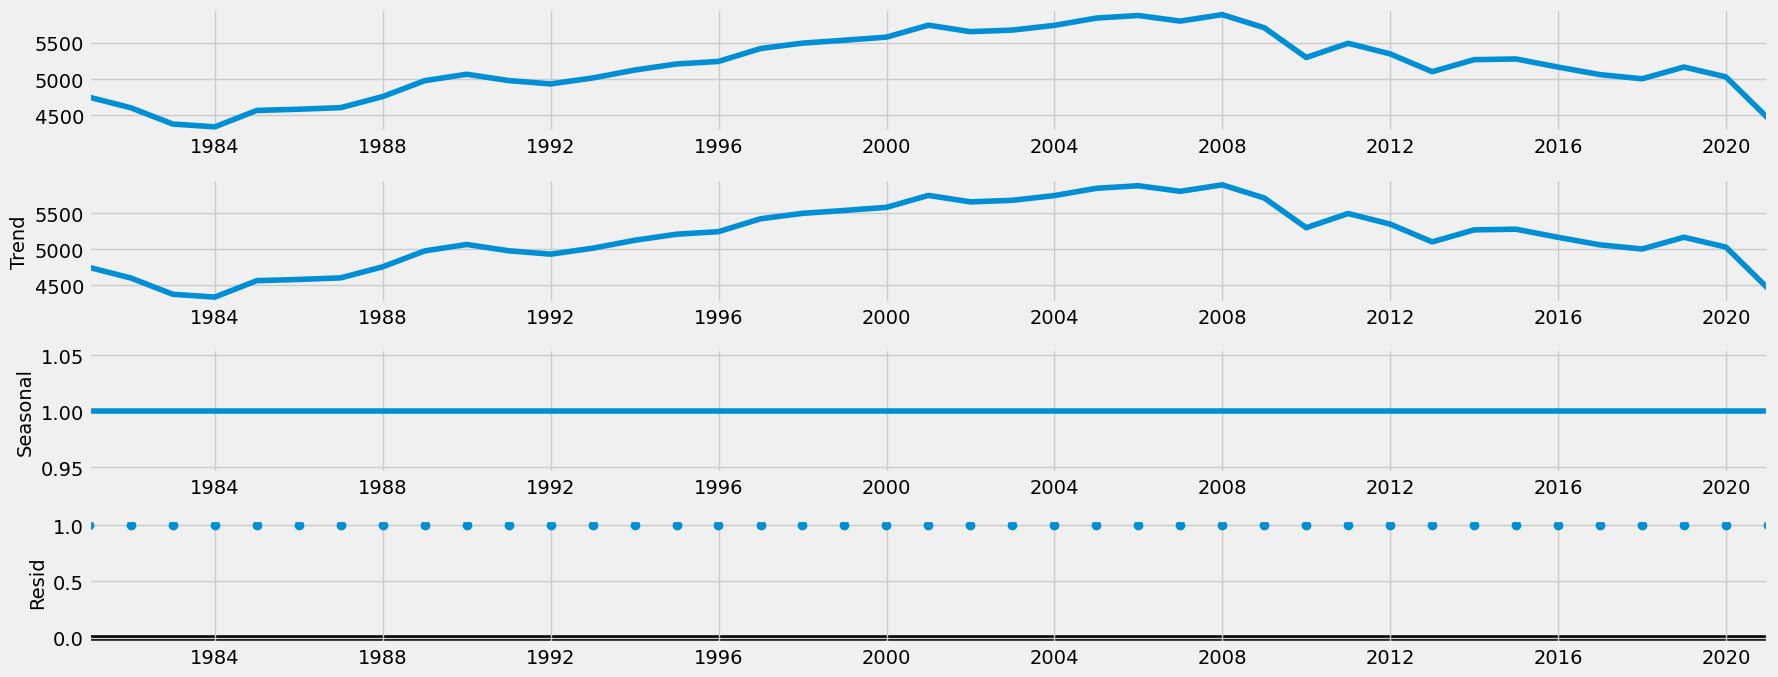

In [17]:
# Ploting the decomposed components

decomposition.plot()
plt.show()

Let's analize the results. <br>
The time series is smooth (frequency is yearly) so basically trend is equal to the level. <br>
The line is flat, so it means there isn't a seasonality component in the time series. <br>
Lastly, it also seems that also there isn't noise in the series, but this should be expected, considering that data is smooth.

This gives us only a glimpse of our data and we can't affirm yet if we are dealing or not with a stationary time series. <br>
We should run a stationarity test.

## 4.2 Stationarity test

To discover the nature of our data, we should run a Dickey-Fuller Test. <br>
This test checks if data contains a unit root, an indicator of non-stationarity. <br>
<br>
Before running the test, I create the following hypothesis: <br>
<b> Null hypothesis:</b> Data contains a unit root (is non-stationary)<br>
<b> Alternative hypothesis:</b> Data doesn't contain a unit root (is stationary)<br>

Let's start by defining a custom function and then applying it to our time series.

In [18]:
# Defining the function
def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_co2_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.343613
p-value                         0.608991
Number of Lags Used             8.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


<b> Results interpretation: </b> <br>
First of all, the p-value is too high (0,6), it should be less than 0,05. <br>
Secondly, the Test statistic value (-1.34) is bigger than the Critical Value 5% (2.96). We aim for a Test statistic value smaller than the Critical value. <br>
According to the test, we can't discard the null hypothesis, so it seems our time series is non-stationary.

Before stationarizing the times series, let's run an autocorrelation test as well.

## 4.3 Autocorrelation test

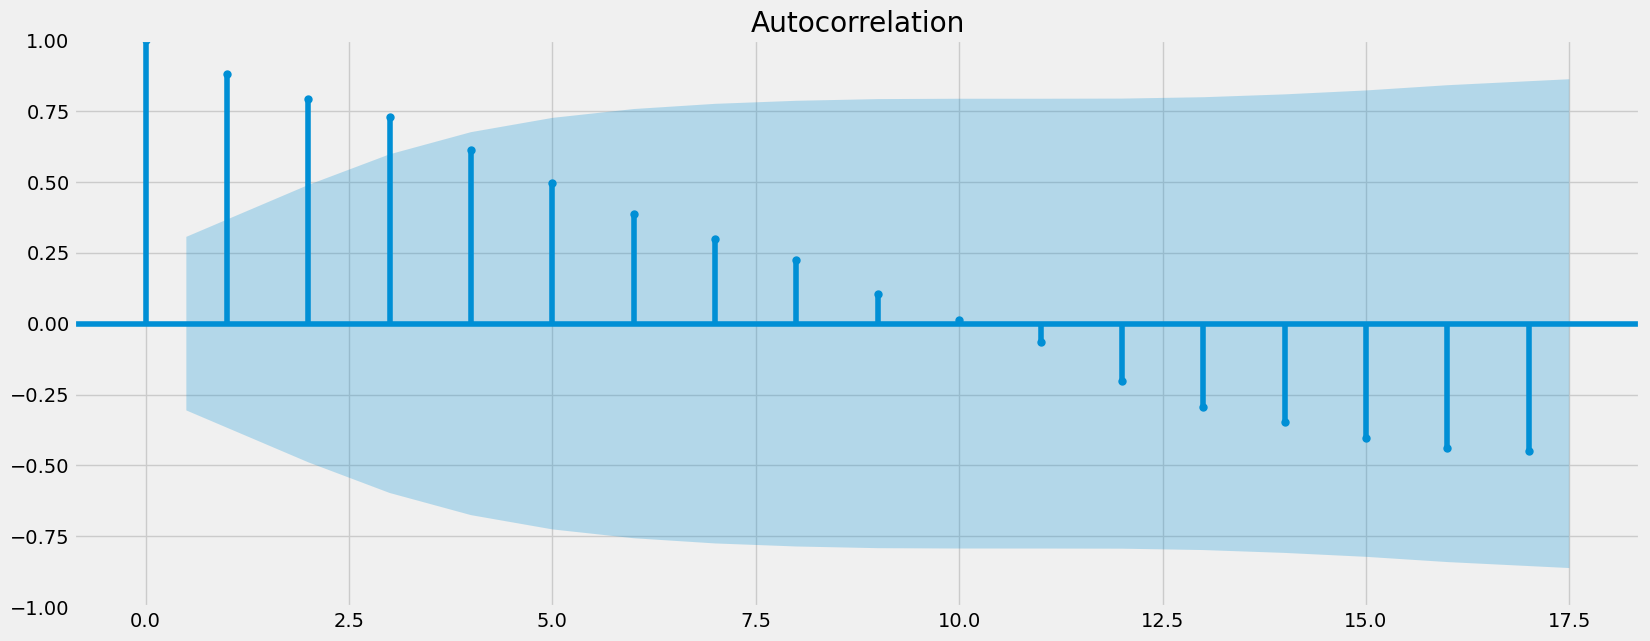

In [19]:
# Running the autocorrelation test
plot_acf(data_co2_sub)
plt.show()

Well, it seems there is a little autocorrelation (4 lags are above the blue confidence interval) but is not a big deal. <br>
I will run another test after the stationarizing process.

# 5. Stationarizing data
** **

To stationarize the time series, I will create a new dataframe and use the differencing method.

In [20]:
# Using the differencing method
data_co2_stat = data_co2_sub - data_co2_sub.shift(1)

The differencing method can generate NaN values. Let's remove them, if there is any.

In [21]:
# Removing NaN
data_co2_stat.dropna(inplace = True)

In [22]:
# Checking the head
data_co2_stat.head()

,Value
datetime,
1981-12-31,-147.665062
1982-12-31,-225.407078
1983-12-31,-38.859306
1984-12-31,227.453376
1985-12-31,16.436492


Let's plot a chart and see how does it look our new time series.

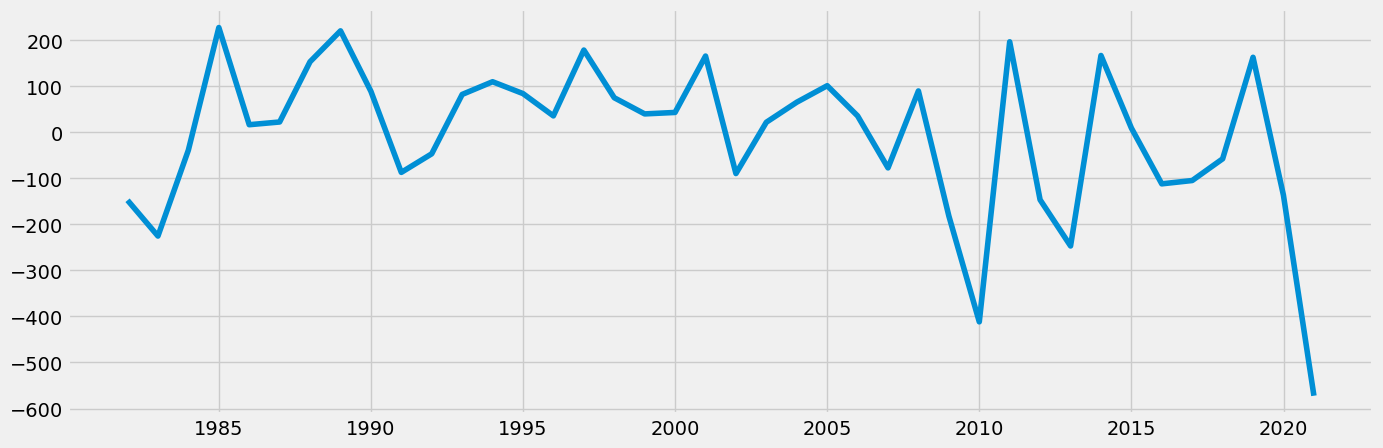

In [23]:
# Plotting the new time series
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_co2_stat)

It surely has a different shape. Is it stationary? To answer this questions, we need to run another test.

# 6. Testing: second round
** **

## 6.1 Stationarity test

Our null hypothesis and alternative hypothesis are the same as before. <br>
We already defined the function, so let's apply again the Dickey-Fuller test to our new time series.

In [24]:
dickey_fuller(data_co2_stat['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.106319
p-value                         0.241981
Number of Lags Used             2.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


<b> Results interpretation: </b> <br>
Our Test statistic value is still bigger than our Critical Value. P-value is still bigger than 0.05. <br>
We need to perform another round of differencing.

# 7. Stationarizing data: second round
** **

In [25]:
# Creating a new dataframe and using the differencing method
data_co2_stat_2 = data_co2_stat - data_co2_stat.shift(1)

In [26]:
# Removing NaN
data_co2_stat_2.dropna(inplace = True)

In [27]:
# Checking the head
data_co2_stat_2.head()

,Value
datetime,
1982-12-31,-77.742016
1983-12-31,186.547772
1984-12-31,266.312682
1985-12-31,-211.016884
1986-12-31,5.899999


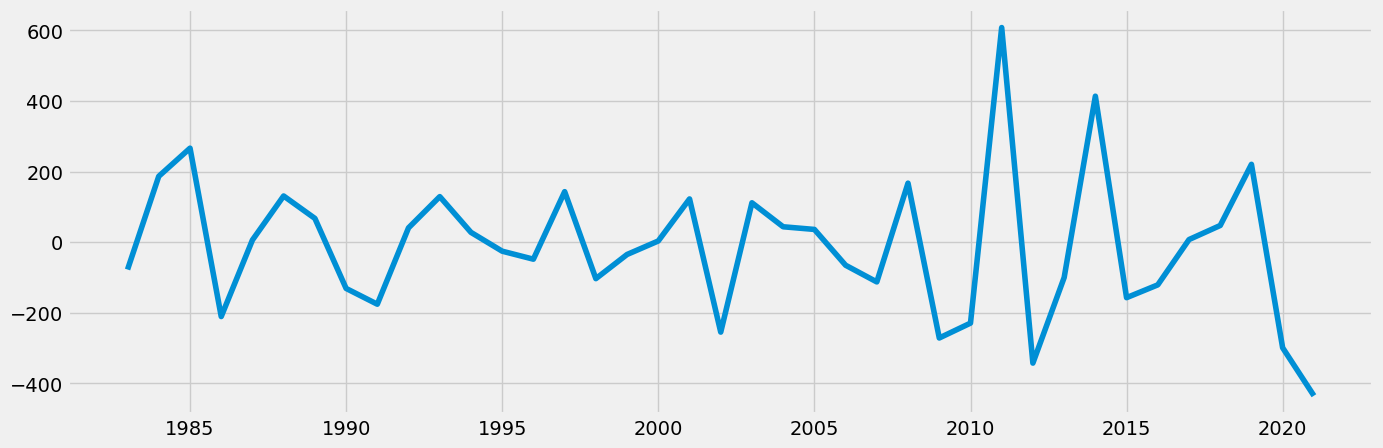

In [28]:
# Plotting the new time series
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_co2_stat_2)

Done. Let's start the third round of testing.

# 8. Testing: third round
** **

## 8.1 Stationarity test

In [29]:
# Applying the test to the new time series
dickey_fuller(data_co2_stat_2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.887125
p-value                         0.002132
Number of Lags Used             6.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


<b> Success! </b> <br>
The p-value is smaller than 0.05. <br>
The Test statistics value is smaller than the Critical Value (5%). <br>
According to test's results, we can discard the null hypothesis and affirm with a 95% interval of confidence and consider stationary this new time series. <br>
A stationary time series could be used to forecast because its properties does not change over time.

Before concluding our analysis, let's run another autocorrelation test on the new time series.

## 8.2 Autocorrelation test

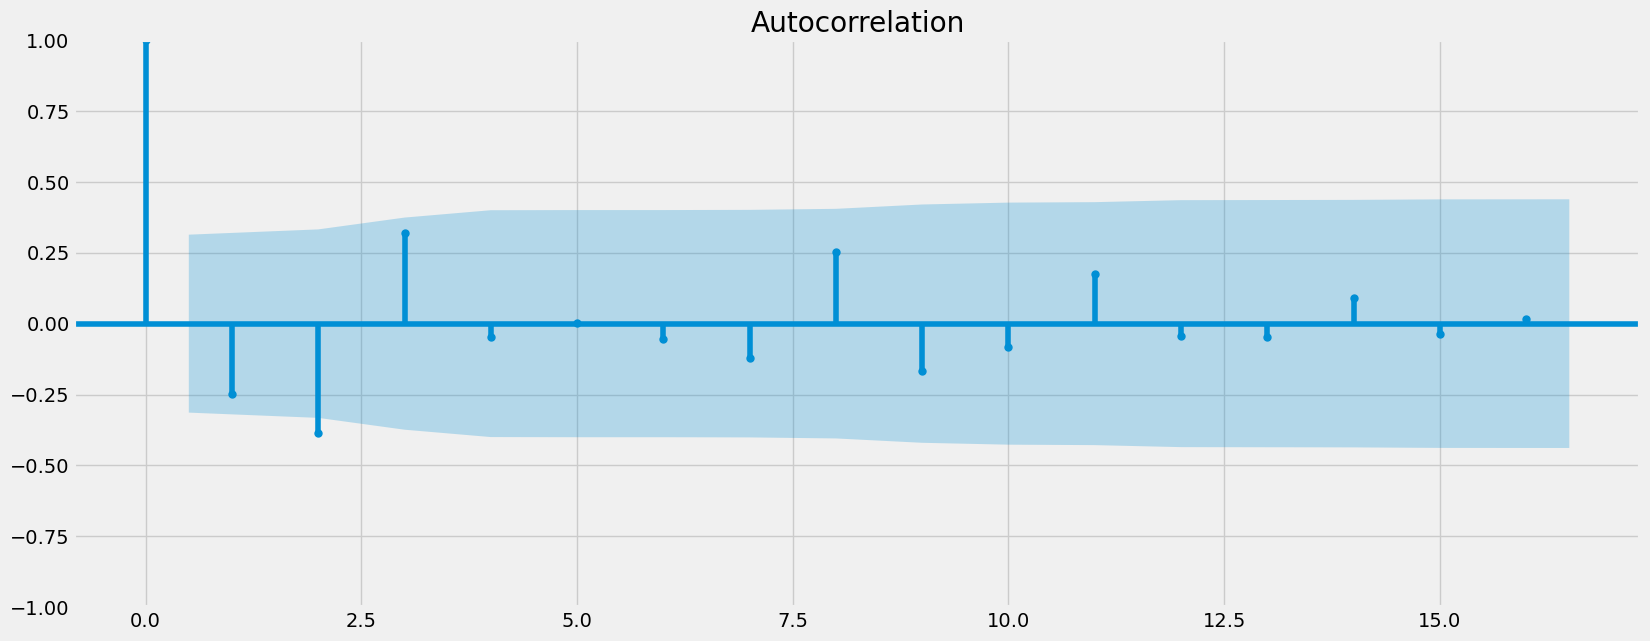

In [30]:
# Running the autocorrelation test on the new time series
plot_acf(data_co2_stat_2)
plt.show()

There are fewer autocorrelated terms in this chart. <br>
Not only the time series is now stationary, but autocorrelation decreased too. <br>
Only two lags are above the confidence interval.